# Phenomenological Synaptic Models

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brainpy/brainpy/blob/master/docs_version2/tutorial_building/phenon_synapse_models.ipynb)
[![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/brainpy/brainpy/blob/master/docs_version2/tutorial_building/phenon_synapse_models.ipynb)

In [1]:
import numpy as np
import brainpy.version2 as bp
import brainpy.version2.math as bm

import matplotlib.pyplot as plt

## ``brainpy.dyn.ProjAlignPostMg2``

![](../_static/align_post.png)


Synaptic projection which defines the synaptic computation with the dimension of postsynaptic neuron group.

```
brainpy.dyn.ProjAlignPostMg2(
   pre, 
   delay, 
   comm, 
   syn, 
   out, 
   post
)
```

- ``pre (JointType[DynamicalSystem, AutoDelaySupp])``: The pre-synaptic neuron group.
- ``delay (Union[None, int, float])``: The synaptic delay.
- ``comm (DynamicalSystem)``: The synaptic communication.
- ``syn (ParamDescInit)``: The synaptic dynamics.
- ``out (ParamDescInit)``: The synaptic output.
- ``post (DynamicalSystem)`` The post-synaptic neuron group.

**CSR sparse matrix**

![](../_static/csr_matrix.png)

The compressed sparse row (CSR) are three NumPy arrays: `indices`, `indptr`, `data`:

- `indices` is array of column indices
- `data` is array of corresponding nonzero values
- `indptr` points to row starts in indices and data
- `length` is n_row + 1, last item = number of values = length of both indices and data
- nonzero values of the i-th row are `data[indptr[i]:indptr[i+1]]` with column indices `indices[indptr[i]:indptr[i+1]]`
- `item (i, j)` can be accessed as `data[indptr[i]+k]`, where `k` is position of `j` in `indices[indptr[i]:indptr[i+1]]`

## Exponential Model

The single exponential decay synapse model assumes the release of neurotransmitter, its diffusion across the cleft, the receptor binding, and channel opening all happen very quickly, so that the channels instantaneously jump from the closed to the open state. Therefore, its expression is given by

$$
g_{\mathrm{syn}}(t)=\bar{g}_{\mathrm{syn}} e^{-\left(t-t_{0}\right) / \tau}
$$

where $\tau$ is the time constant, $t_0$ is the time of the pre-synaptic spike, $\bar{g}_{\mathrm{syn}}$ is the maximal conductance.

The corresponding differential equation:

$$
\frac{d g}{d t} = -\frac{g}{\tau_{decay}}+\sum_{k} \delta(t-t_{j}^{k}).
$$

### COBA

Given the synaptic conductance, the COBA model outputs the post-synaptic current with

$$
I_{syn}(t) = g_{\mathrm{syn}}(t) (E - V(t))
$$


In [2]:
class ExponSparseCOBA(bp.Projection):
  def __init__(self, pre, post, delay, prob, g_max, tau, E):
    super().__init__()
    
    self.proj = bp.dyn.ProjAlignPostMg2(
      pre=pre, 
      delay=delay, 
      comm=bp.dnn.EventCSRLinear(bp.conn.FixedProb(prob, pre=pre.num, post=post.num), g_max),
      syn=bp.dyn.Expon.desc(post.num, tau=tau),
      out=bp.dyn.COBA.desc(E=E),
      post=post, 
    )

In [3]:
class SimpleNet(bp.DynSysGroup):
  def __init__(self, E=0.):
    super().__init__()
    self.pre = bp.dyn.SpikeTimeGroup(1, indices=(0, 0, 0, 0), times=(10., 30., 50., 70.))
    self.post = bp.dyn.LifRef(1, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                              V_initializer=bp.init.Constant(-60.))
    self.syn = ExponSparseCOBA(self.pre, self.post, delay=None, prob=1., g_max=1., tau=5., E=E)
    
  def update(self):
    self.pre()
    self.syn()
    self.post()
    
    # monitor the following variables
    conductance = self.syn.proj.refs['syn'].g
    current = self.post.sum_inputs(self.post.V)
    return conductance, current, self.post.V

In [4]:
def run_a_net(net):
  indices = np.arange(1000)  # 100 ms
  conductances, currents, potentials = bm.for_loop(net.step_run, indices, progress_bar=True)
  ts = indices * bm.get_dt()
  
  # --- similar to: 
  # runner = bp.DSRunner(net)
  # conductances, currents, potentials = runner.run(100.)
  
  fig, gs = bp.visualize.get_figure(1, 3, 3.5, 4)
  fig.add_subplot(gs[0, 0])
  plt.plot(ts, conductances)
  plt.title('Syn conductance')
  fig.add_subplot(gs[0, 1])
  plt.plot(ts, currents)
  plt.title('Syn current')
  fig.add_subplot(gs[0, 2])
  plt.plot(ts, potentials)
  plt.title('Post V')
  plt.show()

Excitatory COBA Exponential synapse

D:\codes\projects\BrainPy\brainpy\version2\mixin.py:399: UserWarning: Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.
  warnings.warn('Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.', UserWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

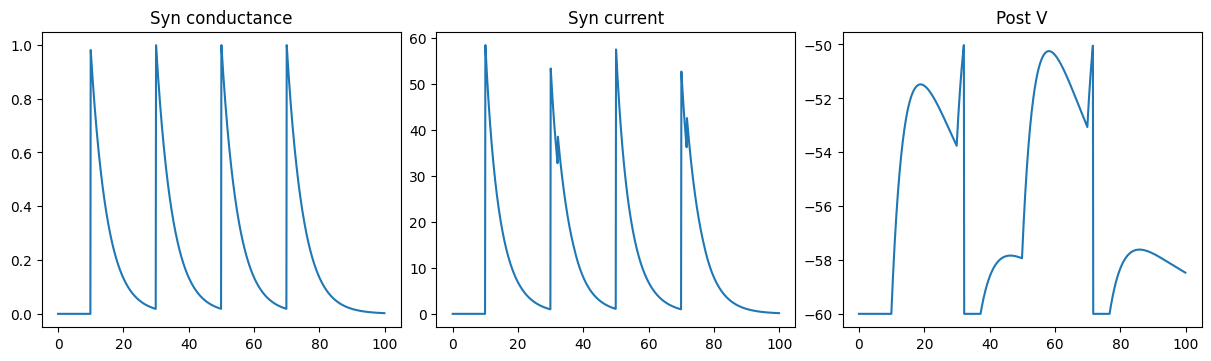

In [5]:
run_a_net(SimpleNet(E=0.))

Inhibitory COBA Exponential synapse

D:\codes\projects\BrainPy\brainpy\version2\mixin.py:399: UserWarning: Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.
  warnings.warn('Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.', UserWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

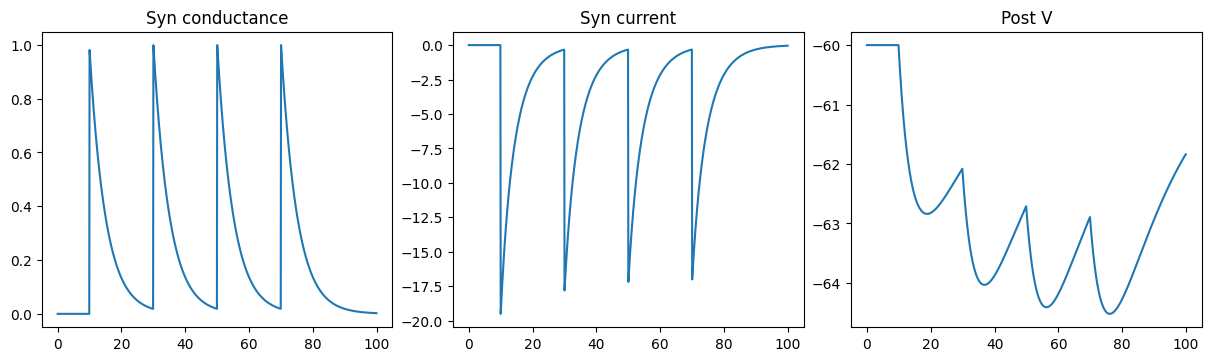

In [6]:
run_a_net(SimpleNet(E=-80.))

### CUBA

Given the conductance, this model outputs the post-synaptic current with a identity function:

$$
I_{\mathrm{syn}}(t) = g_{\mathrm{syn}}(t)
$$

In [7]:
class ExponSparseCUBA(bp.Projection):
  def __init__(self, pre, post, delay, prob, g_max, tau):
    super().__init__()
    
    self.proj = bp.dyn.ProjAlignPostMg2(
      pre=pre, 
      delay=delay, 
      comm=bp.dnn.EventCSRLinear(bp.conn.FixedProb(prob, pre=pre.num, post=post.num), g_max),
      syn=bp.dyn.Expon.desc(post.num, tau=tau),
      out=bp.dyn.CUBA.desc(),
      post=post, 
    )

In [8]:
class SimpleNet2(bp.DynSysGroup):
  def __init__(self, g_max=1.):
    super().__init__()
    
    self.pre = bp.dyn.SpikeTimeGroup(1, indices=(0, 0, 0, 0), times=(10., 30., 50., 70.))
    self.post = bp.dyn.LifRef(1, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                              V_initializer=bp.init.Constant(-60.))
    self.syn = ExponSparseCUBA(self.pre, self.post, delay=None, prob=1., g_max=g_max, tau=5.)
    
  def update(self):
    self.pre()
    self.syn()
    self.post()
    
    # monitor the following variables
    conductance = self.syn.proj.refs['syn'].g
    current = self.post.sum_inputs(self.post.V)
    return conductance, current, self.post.V

Excitatory CUBA Exponential synapse

D:\codes\projects\BrainPy\brainpy\version2\mixin.py:399: UserWarning: Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.
  warnings.warn('Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.', UserWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

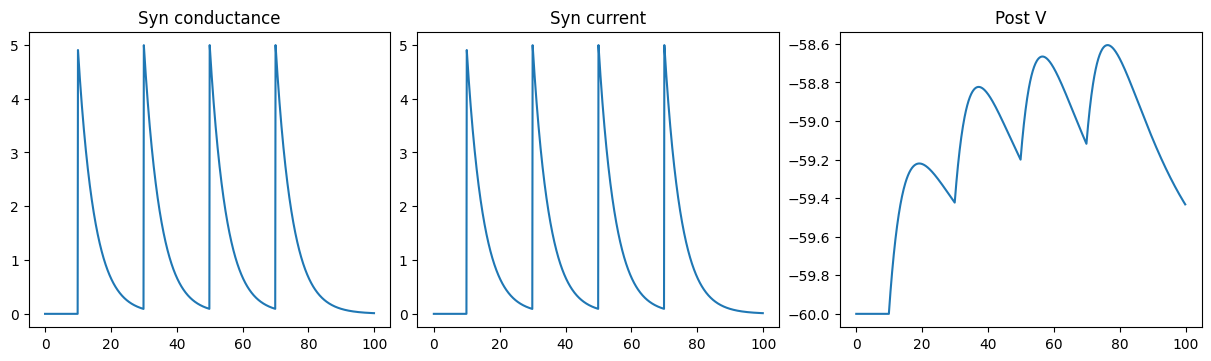

In [9]:
run_a_net(SimpleNet2(g_max=5.))

Inhibitory CUBA Exponential synapse

D:\codes\projects\BrainPy\brainpy\version2\mixin.py:399: UserWarning: Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.
  warnings.warn('Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.', UserWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

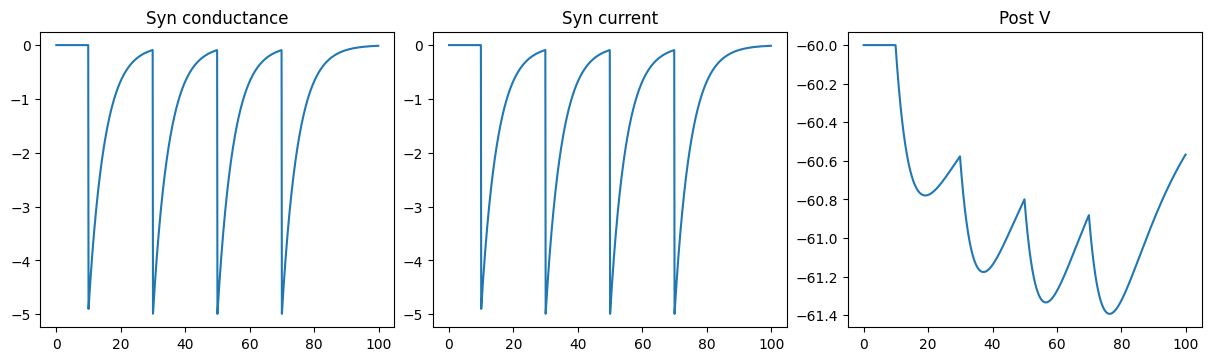

In [10]:
run_a_net(SimpleNet2(g_max=-5.))

### Dense connections

Exponential synapse model with the conductance-based (COBA) output current and dense connections. 

In [11]:
class ExponDenseCOBA(bp.Projection):
  def __init__(self, pre, post, delay, prob, g_max, tau, E):
    super().__init__()
    
    self.proj = bp.dyn.ProjAlignPostMg2(
      pre=pre, 
      delay=delay, 
      comm=bp.dnn.MaskedLinear(bp.conn.FixedProb(prob, pre=pre.num, post=post.num), g_max),
      syn=bp.dyn.Expon.desc(post.num, tau=tau),
      out=bp.dyn.COBA.desc(E=E),
      post=post, 
    )

Masked matrix. 

![](../_static/masked_matrix.png)

Exponential synapse model with the current-based (COBA) output current and dense connections. 

In [12]:
class ExponDenseCUBA(bp.Projection):
  def __init__(self, pre, post, delay, prob, g_max, tau, E):
    super().__init__()
    
    self.proj = bp.dyn.ProjAlignPostMg2(
      pre=pre, 
      delay=delay, 
      comm=bp.dnn.MaskedLinear(bp.conn.FixedProb(prob, pre=pre.num, post=post.num), g_max),
      syn=bp.dyn.Expon.desc(post.num, tau=tau),
      out=bp.dyn.CUBA.desc(),
      post=post, 
    )

## ``brainpy.dyn.ProjAlignPreMg2``

Synaptic projection which defines the synaptic computation with the dimension of presynaptic neuron group.


```
brainpy.dyn.ProjAlignPreMg2(
   pre, 
   delay,
   syn,  
   comm, 
   out, 
   post
)
```

- ``pre (JointType[DynamicalSystem, AutoDelaySupp])``: The pre-synaptic neuron group.
- ``delay (Union[None, int, float])``: The synaptic delay.
- ``syn (ParamDescInit)``: The synaptic dynamics.
- ``comm (DynamicalSystem)``: The synaptic communication.
- ``out (ParamDescInit)``: The synaptic output.
- ``post (DynamicalSystem)`` The post-synaptic neuron group.


![](../_static/align_pre.png)


## Dual Exponential Model

The dual exponential synapse model, also named as *difference of two exponentials model*, is given by:

$$
g_{\mathrm{syn}}(t)=\bar{g}_{\mathrm{syn}} \frac{\tau_{1} \tau_{2}}{\tau_{1}-\tau_{2}}\left(\exp \left(-\frac{t-t_{0}}{\tau_{1}}\right)-\exp \left(-\frac{t-t_{0}}{\tau_{2}}\right)\right)
$$

where $\tau_1$ is the time constant of the decay phase, $\tau_2$ is the time constant of the rise phase, $t_0$ is the time of the pre-synaptic spike, $\bar{g}_{\mathrm{syn}}$ is the maximal conductance.

The corresponding differential equation:

$$
\begin{aligned}
&g_{\mathrm{syn}}(t)=\bar{g}_{\mathrm{syn}} g \\
&\frac{d g}{d t}=-\frac{g}{\tau_{\mathrm{decay}}}+h \\
&\frac{d h}{d t}=-\frac{h}{\tau_{\text {rise }}}+ \delta\left(t_{0}-t\right),
\end{aligned}
$$

The alpha function is retrieved in the limit when both time constants are equal.

In [13]:
class DualExpSparseCOBA(bp.Projection):
  def __init__(self, pre, post, delay, prob, g_max, tau_decay, tau_rise, E):
    super().__init__()
    
    self.proj = bp.dyn.ProjAlignPreMg2(
      pre=pre, 
      delay=delay, 
      syn=bp.dyn.DualExpon.desc(pre.num, tau_decay=tau_decay, tau_rise=tau_rise),
      comm=bp.dnn.CSRLinear(bp.conn.FixedProb(prob, pre=pre.num, post=post.num), g_max),
      out=bp.dyn.COBA(E=E),
      post=post, 
    )

In [14]:
class SimpleNet4(bp.DynSysGroup):
  def __init__(self, E=0.):
    super().__init__()
    
    self.pre = bp.dyn.SpikeTimeGroup(1, indices=(0, 0, 0, 0), times=(10., 30., 50., 70.))
    self.post = bp.dyn.LifRef(1, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                              V_initializer=bp.init.Constant(-60.))
    self.syn = DualExpSparseCOBA(self.pre, self.post, delay=None, prob=1., g_max=1., 
                                 tau_decay=5., tau_rise=1., E=E)
    
  def update(self):
    self.pre()
    self.syn()
    self.post()
    
    # monitor the following variables
    conductance = self.syn.proj.refs['syn'].g
    current = self.post.sum_inputs(self.post.V)
    return conductance, current, self.post.V

Excitatory DualExpon synapse model

D:\codes\projects\BrainPy\brainpy\version2\mixin.py:399: UserWarning: Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.
  warnings.warn('Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.', UserWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

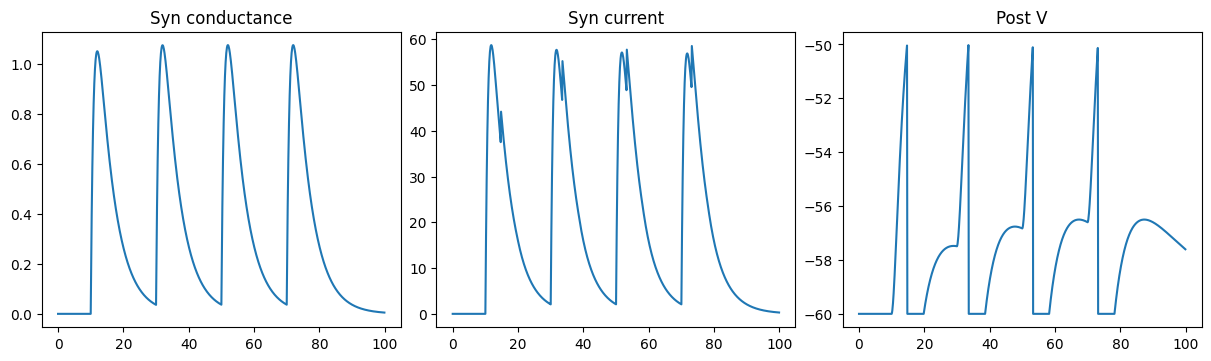

In [15]:
run_a_net(SimpleNet4(E=0.))

Inhibitory DualExpon synapse model

D:\codes\projects\BrainPy\brainpy\version2\mixin.py:399: UserWarning: Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.
  warnings.warn('Please use ".sum_current_inputs()" instead. ".sum_inputs()" will be removed.', UserWarning)


  0%|          | 0/1000 [00:00<?, ?it/s]

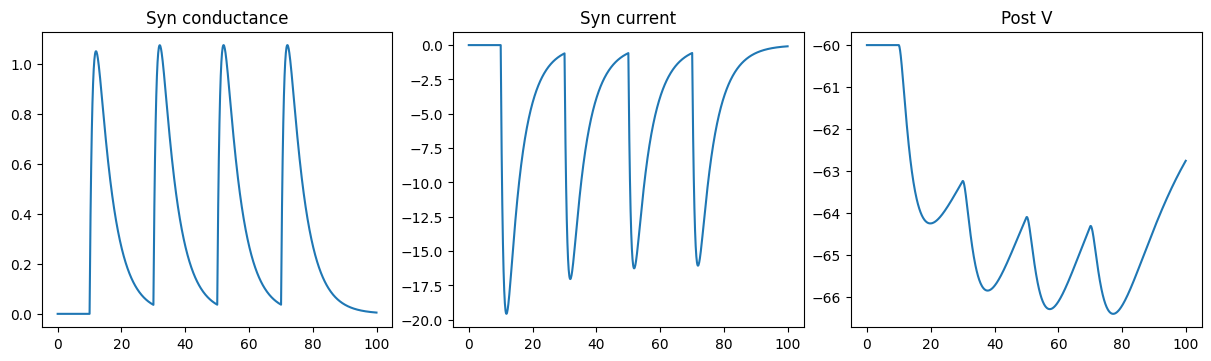

In [16]:
run_a_net(SimpleNet4(E=-80.))

## Problem of Phenomenological Synaptic Models

A significant limitation of the simple waveform description of synaptic conductance is that it does not capture the actual behavior seen at many synapses when trains of action potentials arrive. 

A new release of neurotransmitter soon after a previous release should not be expected to contribute as much to the postsynaptic conductance due to saturation of postsynaptic receptors by previously released transmitter and the fact that some receptors will already be open.

In [17]:
class SimpleNet5(bp.DynSysGroup):
  def __init__(self, freqs=10.):
    super().__init__()
    self.pre = bp.dyn.PoissonGroup(1, freqs=freqs)
    self.post = bp.dyn.LifRef(1, V_rest=-60., V_th=-50., V_reset=-60., tau=20., tau_ref=5.,
                              V_initializer=bp.init.Constant(-60.))
    self.syn = DualExpSparseCOBA(self.pre, self.post, delay=None, prob=1., g_max=1., 
                                 tau_decay=5., tau_rise=1., E=0.)
    
  def update(self):
    self.pre()
    self.syn()
    self.post()
    return self.syn.proj.refs['syn'].g, self.post.V

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

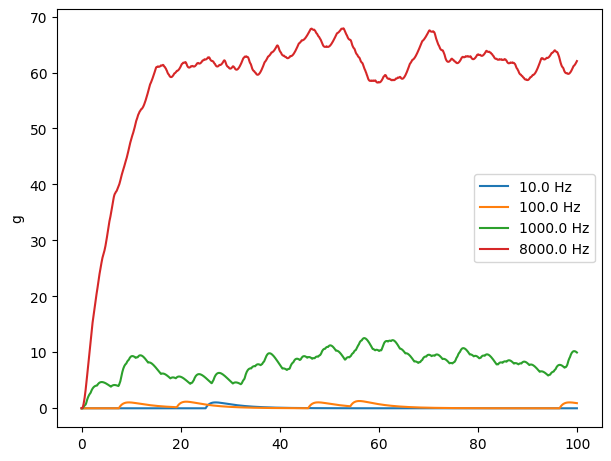

In [18]:
def compare(freqs):
  fig, _ = bp.visualize.get_figure(1, 1, 4.5, 6.)
  for freq in freqs:
    net = SimpleNet5(freqs=freq)
    indices = np.arange(1000)  # 100 ms
    conductances, potentials = bm.for_loop(net.step_run, indices, progress_bar=True)
    plt.plot(indices * bm.get_dt(), conductances, label=f'{freq} Hz')
  plt.legend()
  plt.ylabel('g')
  plt.show()


compare([10., 100., 1000., 8000.])